In [ ]:
!pip install langchain==0.3.8
!pip install langchain_community
!pip install tiktoken
!pip install faiss-cpu
!pip install gradio
!pip install Pillow
!pip install transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 13.1 MB/s eta 0:00:00
  Attempting uninstall: langchain
    Found existing installation: langchain 0.3.9
    Uninstalling langchain-0.3.9:
      Successfully uninstalled langchain-0.3.9


In [ ]:
import langchain
# print(langchain.__version__) #0.3.7
!pip show langchain #Version: 0.3.8


Name: langchain
Version: 0.3.8
Summary: Building applications with LLMs through composability
Home-page: https://github.com/langchain-ai/langchain
Author: 
Author-email: 
License: MIT
Location: /usr/local/lib/python3.10/dist-packages
Requires: aiohttp, async-timeout, langchain-core, langchain-text-splitters, langsmith, numpy, pydantic, PyYAML, requests, SQLAlchemy, tenacity
Required-by: langchain-community


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from google.colab import userdata
import os
import openai

from langchain import hub
from langchain.vectorstores import FAISS
from langchain.text_splitter import CharacterTextSplitter
from langchain.embeddings import OpenAIEmbeddings
from langchain.chains import RetrievalQA
from langchain.agents import create_react_agent, initialize_agent, Tool, ZeroShotAgent, load_tools, AgentExecutor#, create_react_agent #AgentType, create_tool_calling_agent, AgentExecutor #,#
from langchain.chat_models import ChatOpenAI
# from langchain.agents import AgentType
from langchain.memory import ConversationBufferMemory
from langchain.tools import Tool

from sentence_transformers import SentenceTransformer, util
import pandas as pd
import openai
import json
from google.colab import userdata
import os
import re
import ast
import requests
from PIL import Image
from io import BytesIO
from transformers import CLIPTokenizer
import torch

In [ ]:
from langchain.agents import create_react_agent

In [ ]:
# _------ OPENAI API KEY ------------
api_key = userdata.get('OA_API')
os.environ['OPENAI_API_KEY'] = api_key
openai.api_key = os.getenv('OPENAI_API_KEY')


# -----  Models used ---------------
np.random.seed(42)
llm_gpt4 = ChatOpenAI(model="gpt-4o-mini",temperature=0.3)
llm_gpt3 = ChatOpenAI(model="gpt-3.5-turbo",temperature=0)
model_transformer = SentenceTransformer('clip-ViT-B-32')
tokenizer_clip = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")

# ------------ Read DATA ------
data = pd.read_csv("/content/drive/MyDrive/GenAI@IISC_Group6/DB_Amazon_cellphone_features.csv")
data["ProductDetailsFineTuned"] = "-ASIN : " + data["parent_asin"] + "\n" + data["ProductDetailsFineTuned"]
features_list = data["ProductDetailsFineTuned"].tolist()
data.head()

<ipython-input-20-33bf2e290647>:9: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  llm_gpt4 = ChatOpenAI(model="gpt-4o-mini",temperature=0.3)


modules.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/1.91k [00:00<?, ?B/s]

0_CLIPModel/config.json:   0%|          | 0.00/4.03k [00:00<?, ?B/s]

0_CLIPModel/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

0_CLIPModel/special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

0_CLIPModel/vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

0_CLIPModel/preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

0_CLIPModel/tokenizer_config.json:   0%|          | 0.00/604 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

,main_category,title,average_rating,rating_number,features,description,price,images,videos,store,categories,details,parent_asin,bought_together,subtitle,author,Details,ProductDetails,ProductDetailsFineTuned
0,Cell Phones & Accessories,SAMSUNG Galaxy A52A525F128GB 6GB RAMFactory Un...,4.3,685,4G Bands123457812172026283238404166.Cameras64 ...,Behold the comfortablesleek curves on Galaxy A...,199.99,[{'thumb': 'https://m.media-amazon.com/images/...,[{'title': 'Samsung Galaxy A52 - Honest Review...,SAMSUNG,"['Cell Phones & Accessories', 'Cell Phones']",{'Package Dimensions': '7.68 x 4.76 x 2.09 inc...,B098BK2SJ5,NaN,NaN,NaN,Mobile ASIN : B098BK2SJ5\nMobile Brand : samsu...,- Brand Name: Samsung\n- Mobile Name: Samsung ...,-ASIN : B098BK2SJ5\n- Brand Name: Samsung\n- M...
1,Cell Phones & Accessories,Moto G Power20223-Day BatteryUnlockedMade for ...,4.2,655,Carrier compatibilityAT&TVoLTEVerizonVoLTET Mo...,Moto G Power 2022Up to three days of battery l...,129.99,[{'thumb': 'https://m.media-amazon.com/images/...,[{'title': 'Moto G 5g Watch Before You Get It ...,Motorola,"['Cell Phones & Accessories', 'Cell Phones']",{'Product Dimensions': '6.57 x 3.03 x 0.35 inc...,B0BL9TKSBL,NaN,NaN,NaN,Mobile ASIN : B0BL9TKSBL\nMobile Brand : motor...,- Brand Name: Motorola\n- Mobile Name: Moto G ...,-ASIN : B0BL9TKSBL\n- Brand Name: Motorola\n- ...
2,Cell Phones & Accessories,Apple iPhone 14 Plus512GB(PRODUCTRedUnlocked (...,4.5,225,6.7-inch Super Retina XDR displayadvanced came...,The iPhone 14 Plus is an excellent choice if y...,909.89,[{'thumb': 'https://m.media-amazon.com/images/...,[{'title': 'iPhone 14 vs iPhone 14 Plus - Size...,Amazon Renewed,"['Cell Phones & Accessories', 'Cell Phones']","{'Package Dimensions': '8 x 5 x 3 inches', 'It...",B0BY5V82W4,NaN,NaN,NaN,Mobile ASIN : B0BY5V82W4\nMobile Brand : amazo...,- Brand Name: Amazon Renewed\n- Mobile Name: A...,-ASIN : B0BY5V82W4\n- Brand Name: Amazon Renew...
3,Cell Phones & Accessories,SAMSUNG Galaxy S23 Cell PhoneFactory Unlocked ...,4.4,64,CAPTURE THE NIGHT IN LOW LIGHTWhether youâ€™re...,Meet Galaxy S23the phone takes you out of the ...,759.99,[{'thumb': 'https://m.media-amazon.com/images/...,[{'title': 'Do this as soon as you get your S2...,SAMSUNG,"['Cell Phones & Accessories', 'Cell Phones']",{'Package Dimensions': '6.38 x 3.46 x 1.06 inc...,B0BXKWGCSW,NaN,NaN,NaN,Mobile ASIN : B0BXKWGCSW\nMobile Brand : samsu...,- Brand Name: Samsung\n- Mobile Name: Samsung ...,-ASIN : B0BXKWGCSW\n- Brand Name: Samsung\n- M...
4,Cell Phones & Accessories,SAMSUNG Galaxy S22Plus 256GB Factory Unlocked ...,4.4,136,Renewed conditionMay have few minor scuffs or ...,Meet the SAMSUNG Galaxy S22the smartphone that...,493.00,[{'thumb': 'https://m.media-amazon.com/images/...,"[{'title': 'Samsung S22 Ultra', 'url': 'https:...",Amazon Renewed,"['Cell Phones & Accessories', 'Cell Phones']","{'Product Dimensions': '3 x 0.3 x 6 inches', '...",B0B4VCQ7MB,NaN,NaN,NaN,Mobile ASIN : B0B4VCQ7MB\nMobile Brand : amazo...,- Brand Name: Amazon Renewed\n- Mobile Name: S...,-ASIN : B0B4VCQ7MB\n- Brand Name: Amazon Renew...


In [ ]:
def extract_input_features(text, model="gpt-3.5-turbo"):
    """
    Extract features using OpenAI's chat-based models.

    :param text: The input text describing a product.
    :param model: OpenAI model to use for feature extraction.
    :return: Extracted features as text.
    """
    response = openai.chat.completions.create(
        model=model,
        messages=[
            {"role": "system", "content": "You are an assistant that extracts key features of products."},
            {"role": "user", "content": f"Extract and list the key features which are available from ⁠Brand Name,⁠ ⁠⁠Mobile Name, ⁠⁠Processor, ⁠Storage, ⁠RAM, ⁠Camera, ⁠⁠Price, Sim Type, ⁠⁠Battery Life, ⁠Average Rating, ⁠⁠Count of Rating and ⁠Screen Details of the following product:\n Text : {text}.\n Make sure to provide information only from Text\n If feature details are not available in Text, Provide NA only with respect to that feature."}
        ],
        max_tokens=300,
        temperature=0.3
    )
    return response.choices[0].message.content.strip()

def recommend_similar_features(input_feature_text):
    """
    Recommend products with similar features.

    :param input_feature_text: Input features as text.
    :param product_descriptions: List of product descriptions.
    :return: List of recommended products sorted by similarity.
    """

    vectorizer = TfidfVectorizer()
    feature_vectors = vectorizer.fit_transform(
        ["\n".join([v
                    for v in extract_input_features(input_feature_text).split("\n")
                    if "NA" not in v and "Not" not in v])] + features_list
        )

    # Compute cosine similarity
    similarity_scores = cosine_similarity(feature_vectors[0:1], feature_vectors[1:]).flatten()

    # Sort products by similarity
    sorted_indices = np.argsort(-similarity_scores)
    recommendations = pd.DataFrame([
        {
            "features": features_list[idx],
            "similarity_score": similarity_scores[idx]
        }
        for idx in sorted_indices
    ])
    recommendations = recommendations[recommendations["similarity_score"]>=0.1].sort_values(by="similarity_score",ascending=False).head(5)["features"].values
    return "\n\n".join(recommendations)


In [ ]:
features_tool = Tool(
    name = "RecommendSimilarFeatures",
    func = recommend_similar_features,
    description = (
        "Recommend similar products based on features. "
        "Provide input features and a list of product descriptions."
    )
)

recommendation_agent = initialize_agent(
    tools=[features_tool],
    llm= llm_gpt4,
    # agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    verbose=True,
    memory=ConversationBufferMemory(),
)

input_product = "Suggest me mobile with Snapdragon 690"

response = recommendation_agent.run(input_product)
print(response)



> Entering new AgentExecutor chain...
I need to find mobile phones that are equipped with the Snapdragon 690 processor. This will help me provide a list of suitable options. 
Action: RecommendSimilarFeatures
Action Input: "mobile with Snapdragon 690"
Observation: -ASIN : B07XYKK71P
- Brand Name: OnePlus
- Mobile Name: OnePlus Nord N10 5G Global/EU Version
- Processor: Qualcomm Snapdragon 690 5G
- Storage: 128GB UFS 2.1, expandable up to 512GB
- RAM: 6GB LPDDR4X
- Camera: 
  - Rear Camera: 64MP main + 8MP ultra-wide + 2MP macro + 2MP monochrome
  - Front Camera: 16MP
- Price: $299.99
- Sim Type: GSM Unlocked (Works with T-Mobile, AT&T, Metro, etc.)
- Summary of Description: Great budget Android smartphone with 6.49-inch FHD display, 90Hz refresh rate, quad-camera setup, Snapdragon 690 processor, and 4300mAh battery with Warp Charge 30T fast charging.
- Battery Life: 4300mAh (non-removable)
- Average Rating: 4.1
- Count of Rating: 48
- Screen Details: 6.49 inches, FHD (1080x2400), 90Hz

In [ ]:
print(response)

Here are two mobile phones with the Snapdragon 690 processor:
1. **OnePlus Nord N10 5G Global/EU Version**
   - Processor: Qualcomm Snapdragon 690 5G
   - Storage: 128GB (expandable up to 512GB)
   - RAM: 6GB
   - Rear Camera: 64MP + 8MP + 2MP + 2MP
   - Front Camera: 16MP
   - Price: $299.99
   - Battery: 4300mAh
   - Screen: 6.49 inches, FHD (1080x2400), 90Hz refresh rate
   - Average Rating: 4.1

2. **OnePlus Nord N10 5G**
   - Processor: Qualcomm SM6350 Snapdragon 690 5G
   - Storage: 128GB
   - RAM: 6GB
   - Rear Camera: 64MP + 8MP + 2MP + 2MP
   - Front Camera: 16MP
   - Price: $249.00
   - Screen: 6.49 inches, FHD (1080x2400), 90Hz refresh rate
   - Average Rating: 4.0

Both options are great choices if you're looking for a mobile with the Snapdragon 690 processor.


In [ ]:

def create_price_agent(data,column1,column2,column3):
    text_splitter = CharacterTextSplitter(chunk_size=50, chunk_overlap=20,separator='\n\n')
    texts = text_splitter.create_documents(data[column1].astype(str).tolist())
    print(texts)

    embeddings = OpenAIEmbeddings()
    db = FAISS.from_documents(texts, embeddings)
    docsearch = FAISS.from_documents(texts, embeddings)
    qa = RetrievalQA.from_chain_type(llm= llm_gpt4, chain_type="stuff", retriever=docsearch.as_retriever(search_kwargs={"k":3}))
    tool = Tool(
        name=f"{column1}",
        func= qa.run,
        description=f"""Useful for when you need to answer questions about
        the {column1} column in the Amazon Cell Phones dataset.
        The price {column2} for each phone is listed next to the phone name {column3}
        Only fetch answer from document search the price about cell phones {column2},in the context of cell phone price
        not about other products or off-topic questions.
        Always say "thanks for asking!" at the end of the answer.""",
    )
    return tool

data['price_search'] = 'Phone=' + data['title'] + ",Price=" + data['price'].astype(str)
price_tool = create_price_agent(data,column1="price_search",column2="price",column3="title")

price_agent = initialize_agent(
    tools=[price_tool],
    llm= llm_gpt4,
    agent=AgentType.CONVERSATIONAL_REACT_DESCRIPTION,
    verbose=True,
    memory=ConversationBufferMemory(),  # Add memory for context
)

reAct_prompt = hub.pull("hwchase17/react")

# Create the agent
price_agent = create_react_agent(
    llm= llm_gpt4,
    tools=[price_tool],
    prompt=reAct_prompt,
    stop_sequence=True,
)

# Create the agent executor
price_agent_executor = AgentExecutor.from_agent_and_tools(
    agent = price_agent,
    tools = [price_tool],
    verbose = True,
)

user_query = "search for phones under the price of $50 "
response = price_agent_executor.invoke({"input": user_query})
print(response["output"])

[Document(metadata={}, page_content='Phone=SAMSUNG Galaxy A52A525F128GB 6GB RAMFactory Unlocked (GSM ONLYNot Compatible with Verizon/Sprint/BoostInternational Model (Awesome Purple),Price=199.99'), Document(metadata={}, page_content='Phone=Moto G Power20223-Day BatteryUnlockedMade for US by Motorola4/64GB50 MP CameraDark Grove,Price=129.99'), Document(metadata={}, page_content='Phone=Apple iPhone 14 Plus512GB(PRODUCTRedUnlocked (Renewed),Price=909.89'), Document(metadata={}, page_content='Phone=SAMSUNG Galaxy S23 Cell PhoneFactory Unlocked Android Smartphone256GB Storage50MP CameraNight ModeLong Battery LifeAdaptive DisplayUS Version2023Phantom Black,Price=759.99'), Document(metadata={}, page_content='Phone=SAMSUNG Galaxy S22Plus 256GB Factory Unlocked SM-S906U1 Pink Gold (Renewed),Price=493.0'), Document(metadata={}, page_content='Phone=ZTE Cymbal Z-320 Flip Phone UNLOCKED (T-Mobile),Price=89.0'), Document(metadata={}, page_content='Phone=Apple iPod Touch 16GB (5th GenerationSpace Gra

/usr/local/lib/python3.10/dist-packages/langsmith/client.py:241: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(




> Entering new AgentExecutor chain...
I need to find cell phones that are priced under $50. 
Action: price_search
Action Input: {"max_price": 50}The only phone available within the max price of $50 is the BLU Grand Max Unlocked Dual SIM Smartphone, which is priced at $44.99.I now know the final answer.  
Final Answer: The only phone available under the price of $50 is the BLU Grand Max Unlocked Dual SIM Smartphone, which is priced at $44.99. Thanks for asking!

> Finished chain.
The only phone available under the price of $50 is the BLU Grand Max Unlocked Dual SIM Smartphone, which is priced at $44.99. Thanks for asking!


In [ ]:
from langchain import OpenAI
llm_text = OpenAI(model_name="gpt-3.5-turbo")
llm_text

# Define a routing function using LLM
def route_query_to_agent(user_query):
    routing_prompt = (
        "You are an intelligent assistant that routes user queries to specific agents. "

        "Based on the requested features in user query determine which agent should handle it:\n"
        f"User Query: {user_query}\n"
        " Use price_tool if Price details found, ; "
        " Use features_tool if features {Brand Name, RAM, Storage, Camera, Price, Sim Type, Battery Life, Screen Details, Processor} found :\n"  # determine which agent should handle it

        "Available agents are:\n"
        "1. features_tool\n"
        "2. price_tool\n"
        "3. ImageSearchTool\n"
        "Respond with all the names of appropriate agent in comma separated python list."
    )
        # Modified section to fix the issue
    response = openai.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[{"role": "user", "content": routing_prompt}],
    )
    return response.choices[0].message.content.strip()

# Main function for handling user input and routing
def orchestrate_agents(user_query):
    agent_name = route_query_to_agent(user_query).strip()
    print(agent_name)

    # if agent_name == "features_tool":
    #     return recommendation_agent({"input": user_query})
    # elif agent_name == "price_tool":
    #     return price_agent({"input": user_query})
    # elif agent_name == "ImageSearchTool":
    #     return image_agent({"input": user_query})
    # else:
    #     return "I'm sorry, I didn't understand your query."




/usr/local/lib/python3.10/dist-packages/langchain_community/llms/openai.py:255: UserWarning: You are trying to use a chat model. This way of initializing it is no longer supported. Instead, please use: `from langchain_community.chat_models import ChatOpenAI`
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/langchain_community/llms/openai.py:1086: UserWarning: You are trying to use a chat model. This way of initializing it is no longer supported. Instead, please use: `from langchain_community.chat_models import ChatOpenAI`
  warnings.warn(


In [ ]:
input_feature_text = "Suggest me mobile under 200$"
prompt_features = "\n".join([v
                    for v in extract_input_features(input_feature_text).split("\n")
                    if "NA" not in v and "Not" not in v])
print(prompt_features)
orchestrate_agents(prompt_features)

NameError: name 'extract_input_features' is not defined

In [ ]:
# SENTENCE TRANSFORMER

# ------- Preprocessing Image URLS ---------
def extract_image_data(image_data):
  image_ls = (image_data[1:-1])
  large = ""
  thumbs = ""
  try:
    image_list = ast.literal_eval(image_ls)
    filtered_image_list = [item for item in image_list if item] #remove empty dict
    large = [item.get('large') for item in filtered_image_list if item.get('large')]
    if not large:
      print("empty large")
      thumbs = [item.get('thumb') for item in filtered_image_list if item.get('thumb')]
  except (SyntaxError, ValueError, AttributeError) as e:
    return ""

  return str(large) if large else str(thumbs) #return thumbs if large is empty

def extract_image_urls(image_string):
    try:
        image_urls = ""
        image_list = ast.literal_eval(image_string)
        if isinstance(image_list, list):
            for image_url in image_list:
                return image_url
                # image_urls = image_urls + image_url + ", "
            # return image_urls
        else:
            return ""
    except (SyntaxError, ValueError):
        print("Invalid image string format")
        return ""

# ------- Preprocessing Image URLS ---------

data['feature_extract'] = data['ProductDetails'].astype(str) + ", Price:" + data['price'].astype(str) + ", Average Rating:" + data['average_rating'].astype(str)
data['image_filtered'] = data['images'].apply(extract_image_data)
data['image_urls'] = data['image_filtered'].apply(extract_image_urls)
data = data[data['image_filtered'] != ""]
data = data[data['image_urls'] != ""]

product_data= data.reset_index(drop=True).to_dict(orient='index')

Invalid image string format
Invalid image string format
Invalid image string format
Invalid image string format
Invalid image string format
Invalid image string format
Invalid image string format
Invalid image string format
Invalid image string format
Invalid image string format
Invalid image string format
Invalid image string format


In [ ]:
# ---------- TEXT IMAGE EMBEDDINGS ---------------

# Function to download and open an image from a URL
def get_image_from_url(url):
    try:
        response = requests.get(url)
        response.raise_for_status()
        image = Image.open(BytesIO(response.content))
        return image
    except (requests.exceptions.RequestException, IOError):
        return None  # Or handle the error as needed

def generate_image_embeddings(images):
  im_embeddings = []
  for image_url in images:
      image = get_image_from_url(image_url)
      if image:
          # Convert the NumPy array to a PyTorch tensor for model capability
          embeddings = model_transformer.encode(image)
          if isinstance(embeddings, (list, tuple)): # handles multi-image case
              im_embeddings.extend([torch.tensor(emb) for emb in embeddings])
          else:
              im_embeddings.append(torch.tensor(embeddings))
      else:
          print(f"Could not load image from URL: {image_url}")
  return im_embeddings

def truncate_text(text, max_length=74):
    tokens = tokenizer_clip.tokenize(text)
    if len(tokens) > max_length:
        tokens = tokens[:max_length - 1] + [tokenizer_clip.eos_token]  # Add EOS token if truncated
    return tokenizer_clip.convert_tokens_to_string(tokens)

def generate_text_embeddings(feature_data):
  feature_data = feature_data.apply(truncate_text) #VIT limitation
  text_embeddings = model_transformer.encode(feature_data.tolist())
  return text_embeddings

image_data = data["image_urls"]
feature_data = data['feature_extract']

image_embeddings = generate_image_embeddings(image_data)
text_embeddings = generate_text_embeddings(feature_data)

In [ ]:
def search_feature_text(query,embeddings):
  query_embedding = model_transformer.encode(query)
  results = util.semantic_search(query_embedding, embeddings, top_k=15)
  return results

def retreive_match_images(results, image_data):
  img_list = []
  images_filtered = []
  for result in results:
      try:
        pid=result['corpus_id']
        img_list.append(image_data[pid])
      except:
        img_list.append("")
  print("Image Links retrieved: " + str(img_list))
  for url in img_list:
    if(url):
      response = requests.get(url)
      response.raise_for_status()
      image = Image.open(BytesIO(response.content))
      images_filtered.append(image)
  return images_filtered

def search_feature_image(query, image_embeddings):
  query_embedding = model_transformer.encode(query)
  results = util.semantic_search(query_embedding, image_embeddings, top_k=15)
  return results


user_query = " 128gb cellphones"
text_results = search_feature_text(user_query, text_embeddings)
print("Matched Feature results: " + str(text_results))



for result in text_results[0]:
    pid = result['corpus_id']


Matched Feature results: [[{'corpus_id': 70, 'score': 0.792151927947998}, {'corpus_id': 80, 'score': 0.7899911999702454}, {'corpus_id': 36, 'score': 0.7881463766098022}, {'corpus_id': 3, 'score': 0.7858003973960876}, {'corpus_id': 15, 'score': 0.781991720199585}, {'corpus_id': 65, 'score': 0.7772204875946045}, {'corpus_id': 74, 'score': 0.7762803435325623}, {'corpus_id': 24, 'score': 0.7754780054092407}, {'corpus_id': 98, 'score': 0.7750368118286133}, {'corpus_id': 75, 'score': 0.7743920087814331}, {'corpus_id': 4, 'score': 0.7742786407470703}, {'corpus_id': 2, 'score': 0.7717530131340027}, {'corpus_id': 69, 'score': 0.7708355188369751}, {'corpus_id': 99, 'score': 0.7645421624183655}, {'corpus_id': 9, 'score': 0.7641452550888062}]]
Matched Image results: [[{'corpus_id': 30, 'score': 0.3011472523212433}, {'corpus_id': 45, 'score': 0.2872501313686371}, {'corpus_id': 102, 'score': 0.2865825295448303}, {'corpus_id': 94, 'score': 0.280901700258255}, {'corpus_id': 5, 'score': 0.2751907110214

Image Links retrieved: ['https://m.media-amazon.com/images/I/41mo2i7i9gL._AC_.jpg', 'https://m.media-amazon.com/images/I/41ss+opZuFL._AC_.jpg', 'https://m.media-amazon.com/images/I/51iHMXzftRL._AC_.jpg', 'https://m.media-amazon.com/images/I/41HzRa-x1IS._AC_.jpg', 'https://m.media-amazon.com/images/I/51SUc-JO9FL._AC_.jpg', 'https://m.media-amazon.com/images/I/41iauuPg5IL._AC_.jpg', 'https://m.media-amazon.com/images/I/41A82wPH67S._AC_.jpg', 'https://m.media-amazon.com/images/I/51YEKl0ZPML._AC_.jpg', 'https://m.media-amazon.com/images/I/41du4H3-AEL._AC_.jpg', 'https://m.media-amazon.com/images/I/316SSdcgG7L._AC_.jpg', 'https://m.media-amazon.com/images/I/51ybpGasrkL._AC_.jpg', 'https://m.media-amazon.com/images/I/31yt1cDkluL._AC_.jpg', 'https://m.media-amazon.com/images/I/417XIlI3eDL._AC_.jpg', 'https://m.media-amazon.com/images/I/419TpEjLvXS._AC_.jpg', '']


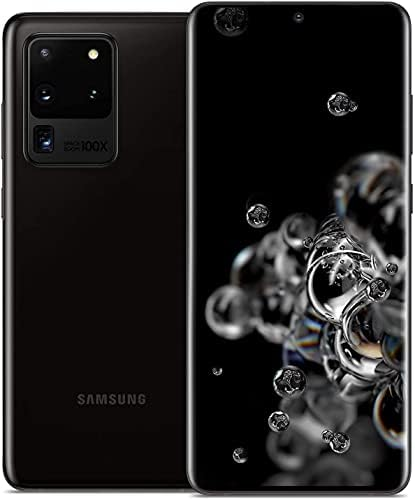

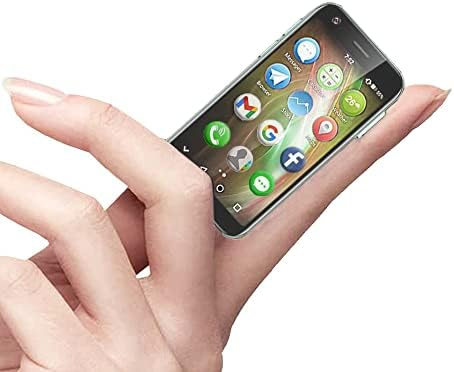

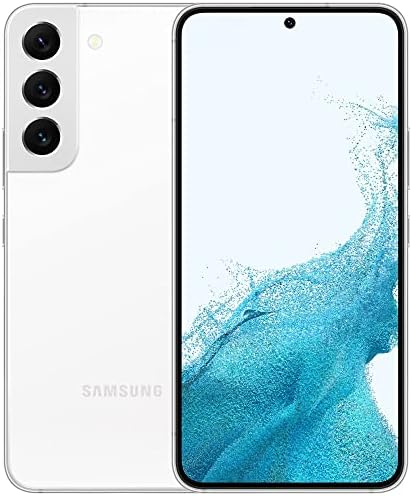

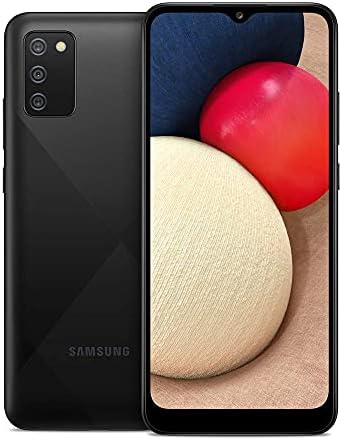

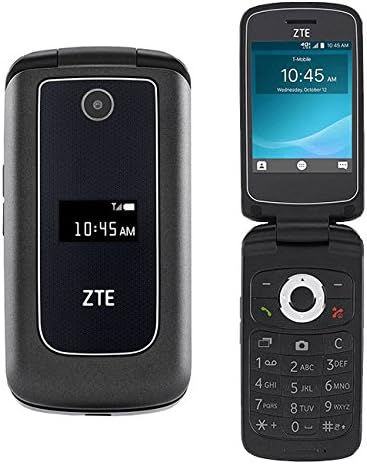

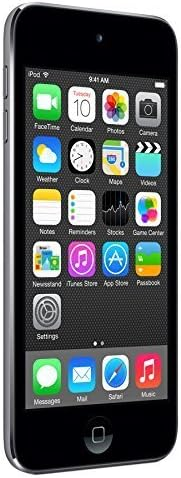

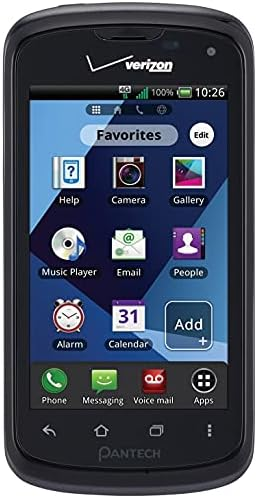

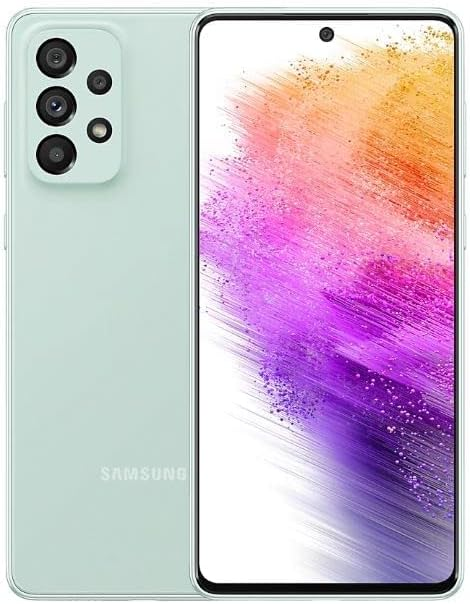

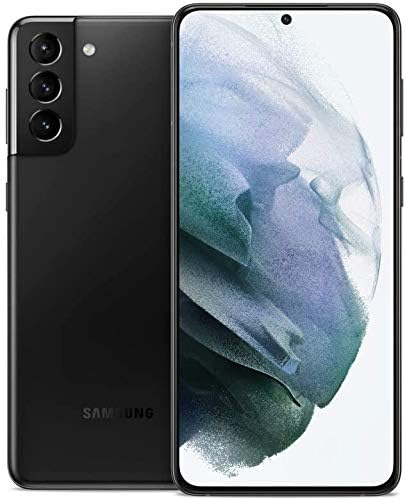

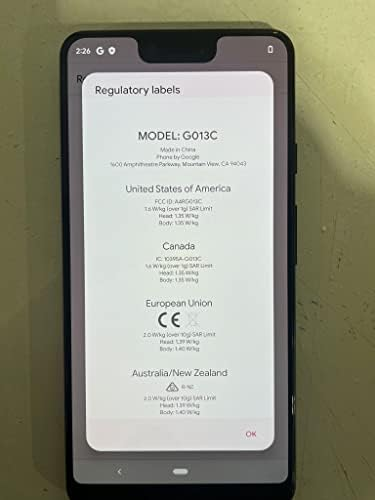

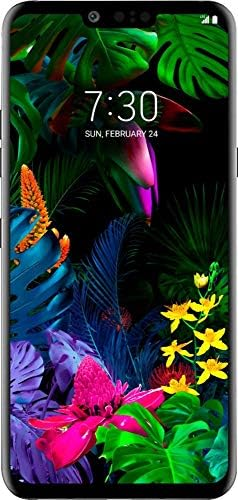

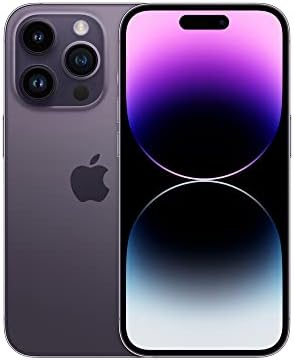

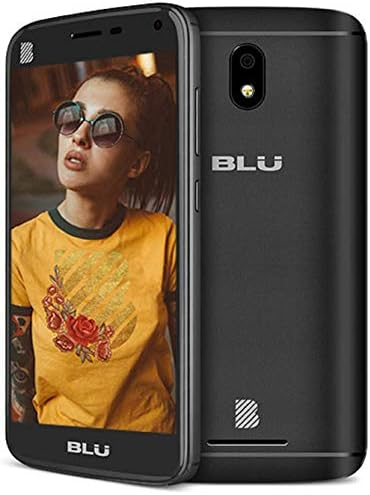

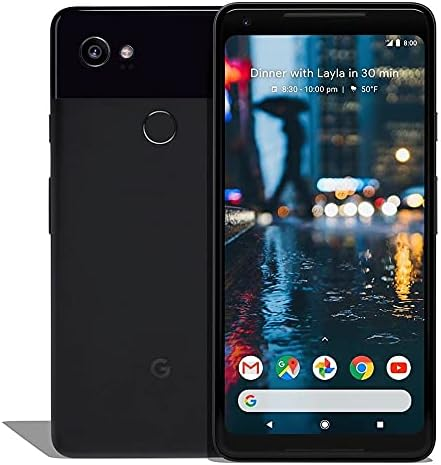

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [ ]:
# image_dt = retreive_match_images(text_results[0], image_data)
# [display(image) for image in image_dt]

query ="black cellphones"
image_results = search_feature_image(query, image_embeddings)
# print("Matched Image results: " + str(image_results))
image_dt = retreive_match_images(image_results[0], image_data)
[display(image) for image in image_dt]

In [ ]:
# prompt: find common corpus_id from tx_results, im_results

common_corpus_ids = []
tx_corpus_ids = [result['corpus_id'] for result in text_results[0]]
im_corpus_ids = [result['corpus_id'] for result in image_results[0]]

for corpus_id in tx_corpus_ids:
    if corpus_id in im_corpus_ids:
        common_corpus_ids.append(corpus_id)

print("Common Corpus IDs:", common_corpus_ids)
print("Text Corpus IDs ", tx_corpus_ids)
print("Image Corpus IDs ", im_corpus_ids)

Common Corpus IDs: [69]
Text Corpus IDs  [70, 80, 36, 3, 15, 65, 74, 24, 98, 75, 4, 2, 69, 99, 9]
Image Corpus IDs  [30, 45, 102, 94, 5, 6, 38, 29, 105, 69, 87, 72, 39, 121, 14]


In [ ]:
# !pip install langchain
# !pip install langchain_community
from dotenv import load_dotenv,find_dotenv
load_dotenv(find_dotenv())

from langchain.chat_models import ChatOpenAI
from langchain.chains.question_answering import load_qa_chain
from langchain.prompts import PromptTemplate
from langchain.docstore.document import  Document


def create_docs(results):
    docs = []
    for result in results[0]:
        pid = result['corpus_id']
        score = result['score']
        result_string = ''
        result_string += "feature_extract:" + str(product_data[pid]['feature_extract']) +  ';' + \
                          "Parent ASIN:" + str(product_data[pid]['parent_asin']) +  ';' + \
                          "Image URLS:" + str(product_data[pid]['image_urls'])
        doc = Document(page_content=result_string)
        doc.metadata['pid'] = str(pid)
        doc.metadata['score'] = score
        docs.append(doc)
    return docs

def recommend_product_features(query):
  results= search_feature_text(query, text_embeddings)
  docs = create_docs(results)
  response=chain({"input_documents": docs, "question": query},return_only_outputs=True)
  return response['output_text']


template = """
You are a E-commerce shopping assistant for cellphone products that wants to convert customers based on the information given.

Provide details like RAM, Storage, Camera, Processor, Screen Size, Parent ASIN information also narrate pros and cons and at the end Recommend why is it good recommendedation given context in your interaction with the customer.

Use a bullet list when describing each product.

Context: {context}

User question:{question}


Your response:"""
prompt = PromptTemplate.from_template(template)

chain = load_qa_chain(ChatOpenAI(model_name= "gpt-3.5-turbo", temperature=0.2), chain_type="stuff", prompt=prompt)

In [ ]:
query="Provide good phones in black color with 512GB storage"
print(recommend_product_features(query))

Based on the user's question for good phones in black color with 512GB storage, here are some recommendations:

1. Apple iPhone 14 Pro 512GB Deep Purple (Unlocked) (Renewed)
   - Price: $1099.66
   - Summary: Powerful phone with amazing cameras, beautiful display, and dynamic island feature
   - Average Rating: 4.4
   - Image: [View Product](https://m.media-amazon.com/images/I/31yt1cDkluL._AC_.jpg)

2. Samsung Galaxy S21 Ultra 5G
   - Price: $1049.97
   - Summary: Epic design, all-day battery life, 120Hz screen refresh rate, 5G connectivity, 100x space zoom, 8K video recording
   - Average Rating: 4.6
   - Image: [View Product](https://m.media-amazon.com/images/I/41Vsckg2YEL._AC_.jpg)

3. Apple iPhone 14 Plus 512GB (Product Red Unlocked)
   - Price: $909.89
   - Summary: All-day battery life, advanced camera features
   - Average Rating: 4.5
   - Image: [View Product](https://m.media-amazon.com/images/I/31TtBSmfTTL._AC_.jpg)

These phones offer high storage capacity, excellent features

In [ ]:
data[data['ProductDetails'].str.contains('Apple iPhone 14 Plus')]

,main_category,title,average_rating,rating_number,features,description,price,images,videos,store,...,parent_asin,bought_together,subtitle,author,Details,ProductDetails,ProductDetailsFineTuned,feature_extract,image_filtered,image_urls
2,Cell Phones & Accessories,Apple iPhone 14 Plus512GB(PRODUCTRedUnlocked (...,4.5,225,6.7-inch Super Retina XDR displayadvanced came...,The iPhone 14 Plus is an excellent choice if y...,909.89,[{'thumb': 'https://m.media-amazon.com/images/...,[{'title': 'iPhone 14 vs iPhone 14 Plus - Size...,Amazon Renewed,...,B0BY5V82W4,NaN,NaN,NaN,Mobile ASIN : B0BY5V82W4\nMobile Brand : amazo...,- Brand Name: Amazon Renewed\n- Mobile Name: A...,-ASIN : B0BY5V82W4\n- Brand Name: Amazon Renew...,- Brand Name: Amazon Renewed\n- Mobile Name: A...,['https://m.media-amazon.com/images/I/31TtBSmf...,https://m.media-amazon.com/images/I/31TtBSmfTT...


In [ ]:

query=" black color"
results = search_feature_image(user_query, image_embeddings)
print("Matched results: " + str(results))
def recommend_image_features(query):
  results= search_feature_text(query, image_embeddings)
  docs = create_docs(results)
  response=chain({"input_documents": docs, "question": query},return_only_outputs=True)
  return response['output_text']

# print(recommend_image_features(query))

Matched results: [[{'corpus_id': 138, 'score': 0.27717089653015137}, {'corpus_id': 102, 'score': 0.27620193362236023}, {'corpus_id': 94, 'score': 0.27395495772361755}, {'corpus_id': 5, 'score': 0.2735900282859802}, {'corpus_id': 45, 'score': 0.27356410026550293}, {'corpus_id': 87, 'score': 0.2716522216796875}, {'corpus_id': 30, 'score': 0.26665711402893066}, {'corpus_id': 117, 'score': 0.2664380371570587}, {'corpus_id': 59, 'score': 0.2634512782096863}, {'corpus_id': 77, 'score': 0.26292216777801514}, {'corpus_id': 38, 'score': 0.2603839039802551}, {'corpus_id': 34, 'score': 0.2601233720779419}, {'corpus_id': 22, 'score': 0.2594684958457947}, {'corpus_id': 17, 'score': 0.25903651118278503}, {'corpus_id': 44, 'score': 0.2575986981391907}]]


In [ ]:
feature_transformer_tool = Tool(
    name = "sentenceTransformerTool",
    func = recommend_product_features,
    description = (
        "Recommend similar products based on features. "
        "Provide input features and a list of product descriptions."
    )
)

image_transformer_tool = Tool(
    name = "sentenceTransformerTool",
    func = recommend_image_features,
    description = (
        "Recommend products based on image color. "
        "Provide input features with color information."
    )
)

recommendation_transformer_agent = initialize_agent(
    tools= [feature_transformer_tool],
    llm= llm_gpt4,
    # agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    verbose=True,
    memory=ConversationBufferMemory(),
)

image_transformer_agent = initialize_agent(
    tools= [image_transformer_tool],
    llm= llm_gpt4,
    # agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    verbose=True,
    memory=ConversationBufferMemory(),
)

# input_product = "Suggest me mobile with Snapdragon 690"
query="Provide good phones in black color with 512GB storage"
response = recommendation_transformer_agent.run(query)
print(response)



> Entering new AgentExecutor chain...
I need to find phones that are available in black color and have 512GB of storage. To do this, I'll use the sentenceTransformerTool to recommend similar products based on these features. 

Action: sentenceTransformerTool  
Action Input: {"color": "black", "storage": "512GB"}  
Observation: Based on your preferences for a black color and 512GB storage, I would recommend the following options:

1. Apple iPhone 14 Pro 512GB Deep Purple (Unlocked) (Renewed)
   - Price: $1099.66
   - Processor: A16 Bionic
   - Camera: 48MP main camera, cinematic mode in 4K Dolby Vision up to 30 fps
   - Summary: Powerful phone with amazing cameras, beautiful display, and dynamic island feature. Pocketable form factor, sheer horsepower, and excellent camera capabilities.
   - Battery Life: Not specified
   - Average Rating: 4.4
   - Screen Details: 6.1-inch Super Retina XDR display featuring always-on promotion, dynamic island feature for interacting with the phone.

2

In [ ]:
# prompt: generate gradio interface with input text for query and text for output should be multiple labels to display product info and to display pros and cons in different section. display Pros with tick mark
!pip install gradio
import gradio as gr

def predict(query):
    # Replace this with your actual logic to process the query
    # and generate product info, pros, and cons.
    product_info = "Product Information:\n- Feature 1: Value 1\n- Feature 2: Value 2\n- Feature 3: Value 3"
    pros = "Pros:\n ✅ Pro 1\n✅ Pro 2\n✔ Pro 3"
    cons = "Cons:\n- Con 1\n- Con 2"
    return product_info, pros, cons

iface = gr.Interface(
    fn=predict,
    inputs=gr.Textbox(lines=2, placeholder="Enter your query here..."),
    outputs=[
        gr.Textbox(label="Product Information"),
        gr.Textbox(label="Pros"),
        gr.Textbox(label="Cons")
    ],
    title="Product Recommendation",
    description="Enter a query to get product recommendations, including pros and cons."
)

iface.launch()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.1/320.1 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 6.1 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2
Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL

In [ ]:
# prompt: add image output from [display(image) for image in image_dt] in gradio interface designed above. i have more than 1 product, how to loop each product and display pros, cons, images of the each product

import gradio as gr
# ... (your existing code) ...

def predict(query):
    product_info_list = []
    pros_list = []
    cons_list = []
    image_list = []

    # Assuming common_corpus_ids holds the IDs of products matching both text and image queries
    for corpus_id in common_corpus_ids:
        product_data_item = product_data.get(corpus_id)
        if product_data_item:
            product_info = f"Product Information:\n{product_data_item['feature_extract']}"
            product_info_list.append(product_info)

            # Use your LLM to generate pros and cons (replace this with your actual logic)
            pros = f"Pros:\n- Pro 1 for {product_data_item['title']}\n- Pro 2" # Example pros
            pros_list.append(pros)
            cons = f"Cons:\n- Con 1 for {product_data_item['title']}\n- Con 2"  # Example cons
            cons_list.append(cons)

            # Retrieve and display the image
            image_url = product_data_item['image_urls']
            if image_url:
                image = get_image_from_url(image_url)
                if image:
                    image_list.append(image)
                else:
                    image_list.append(None)  # Handle cases where image loading fails
            else:
                image_list.append(None)
        else:
            # Handle cases where product data is missing for a given corpus_id
            product_info_list.append("Product information not found.")
            pros_list.append("No pros found.")
            cons_list.append("No cons found.")
            image_list.append(None)


    return product_info_list, pros_list, cons_list, image_list

iface = gr.Interface(
    fn=predict,
    inputs=gr.Textbox(lines=2, placeholder="Enter your query here..."),
    outputs=[
        gr.Gallery(label="Product Information"),  # Changed to Gallery
        gr.Gallery(label="Pros"),  # Changed to Gallery
        gr.Gallery(label="Cons"),   # Changed to Gallery
        gr.Gallery(label="Product Images")  # Added Gallery for Images
    ],
    title="Product Recommendation",
    description="Enter a query to get product recommendations, including pros, cons, and images."
)

iface.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://2f14be03e43d0c9972.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
predict('128gb')

(['Product Information:\n- Brand Name: Amazon Renewed\n- Mobile Name: Apple iPhone 14 Pro 512GB Deep Purple (Unlocked) (Renewed)\n- Processor: A16 Bionic\n- Storage: 512GB\n- RAM: Not specified in the text\n- Camera: 48MP main camera, cinematic mode in 4K Dolby Vision up to 30 fps\n- Price: $1099.66\n- Sim Type: Not specified in the text\n- Summary of Description: The iPhone 14 Pro is described as powerful, with amazing cameras, a beautiful display, and a dynamic island feature. It is praised for its pocketable form factor, sheer horsepower, and camera capabilities, being considered as close to a perfect phone ever seen.\n- Battery Life: Not specified in the text\n- Average Rating: 4.4\n- Count of Rating: 127\n- Screen Details: 6.1-inch Super Retina XDR display featuring always-on promotion, dynamic island feature for interacting with the phone., Price:1099.66, Average Rating:4.4'],
 ['Pros:\n- Pro 1 for Apple iPhone 14 Pro512GBDeep PurpleUnlocked (Renewed)\n- Pro 2'],
 ['Cons:\n- Con 

In [ ]:
# ----------------- Additional Testing or already Tested on --------------------------------
# input_product = 'Recommed me Samsung latest mobile phone'
# input_product = "A samsung mobile with 6.5` screen"
# input_product = "samsung galaxy a51"
# input_product = "4GB RAM and 64GB storage smartphone "
# input_product = '6.5" HD display with 90 Hz'
# input_product = 'I want new Iphone with 512GB Storage and screen size more than 6 inch'
# input_product = 'I want new samsung galaxy S22 ultra'
# input_product = 'Recommed me products with 4GB RAM  4000 Battery and Average Rating more than 4'
# input_product = 'Recommed me products with 6GB RAM and 512GB'
# input_product = 'Recommed me products with 8MP Camera and 6GB RAM'
# input_product = 'Recommed me 16GB Memory'
# input_product = 'Best mobile with 6GB Ram'
input_product = "Suggest me mobile with Snapdragon 690"

response = recommendation_agent.run(input_product)
print(response)